# Deploying TotalSegmentator using Mercure DICOM orchestration software

This notebook demonstrates how to use [Mercure](https://mercure-imaging.org) - a DICOM orchestration platform, to rapidly deploy a CT segmentation tool - [TotalSegmentator](https://github.com/wasserth/TotalSegmentator) into clinical infrastructure. Mercure is open-source software that can be used to send / receive DICOM files, run inference on AI models as post processing modules, and send tracking notifications. This tutorial includes instructions on how to quickly set up a test installation of Mercure in a virtual environment with [virtual box](https://www.virtualbox.org/) and [vagrant](https://www.vagrantup.com/) and then steps through how to deploy and configure the TotalSegmentator app to receive and process files using Mercure. The deployed app is tested by sending and viewing sample data.

### Requirements
- Notebook is Linux/macOS/Windows compatible and needs to be downloaded and run locally.
- Python installed (2.7 | 3.5 | 3.6 | 3.7 | 3.8 | 3.9).
- Git installed.
- VirtualBox and Vagrant installed (see below ).

## 1. Setup Mercure test environment

### 1.1 Install Virtual Box and Vagrant

Vagrant is an open-source tool for automatically creating and provisioning virtual machines. It is used in in this tutorial to simplify Mercure installation and setup. To begin, install VirtualBox followed by Vagrant at the links provided below :

1. Download and install VirtualBox [here.](https://virtualbox.org/)
2. Download and install Vagrant [here.](https://vagrantup.com/)


### 1.2 Install Mercure

Clone Mercure github repository.

In [ ]:
!git clone https://github.com/mercure-imaging/mercure.git

Navigate to 'systemd' subdirectory of Mercure repository and install Mercure with vagrant. This step may take a few minutes and will generate lots of output. The open-source Orthanc PACS and DICOM viewer will be installed so we can view our results later.

In [ ]:
%cd mercure/addons/vagrant/systemd
!vagrant --orthanc up

Mercure should now be running inside a virtual machine and accessible from your host computer. To view the Mercure login screen open address [127.0.0.1:8000](http://127.0.0.1:8000/). 
The credentials for first login are : **Username = admin, Password = router**. A prompt to add email contact and change password will follow.

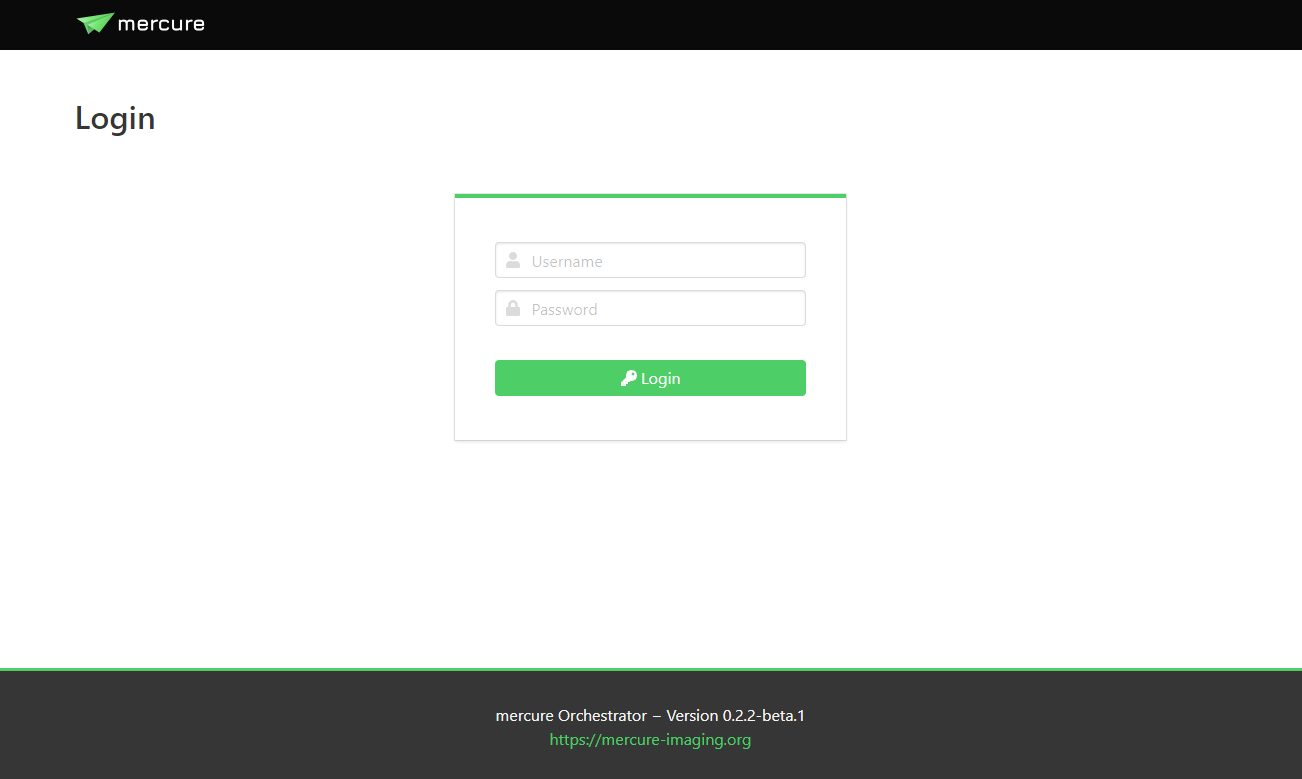

Once logged in you should see the 'Overview' page as shown below.

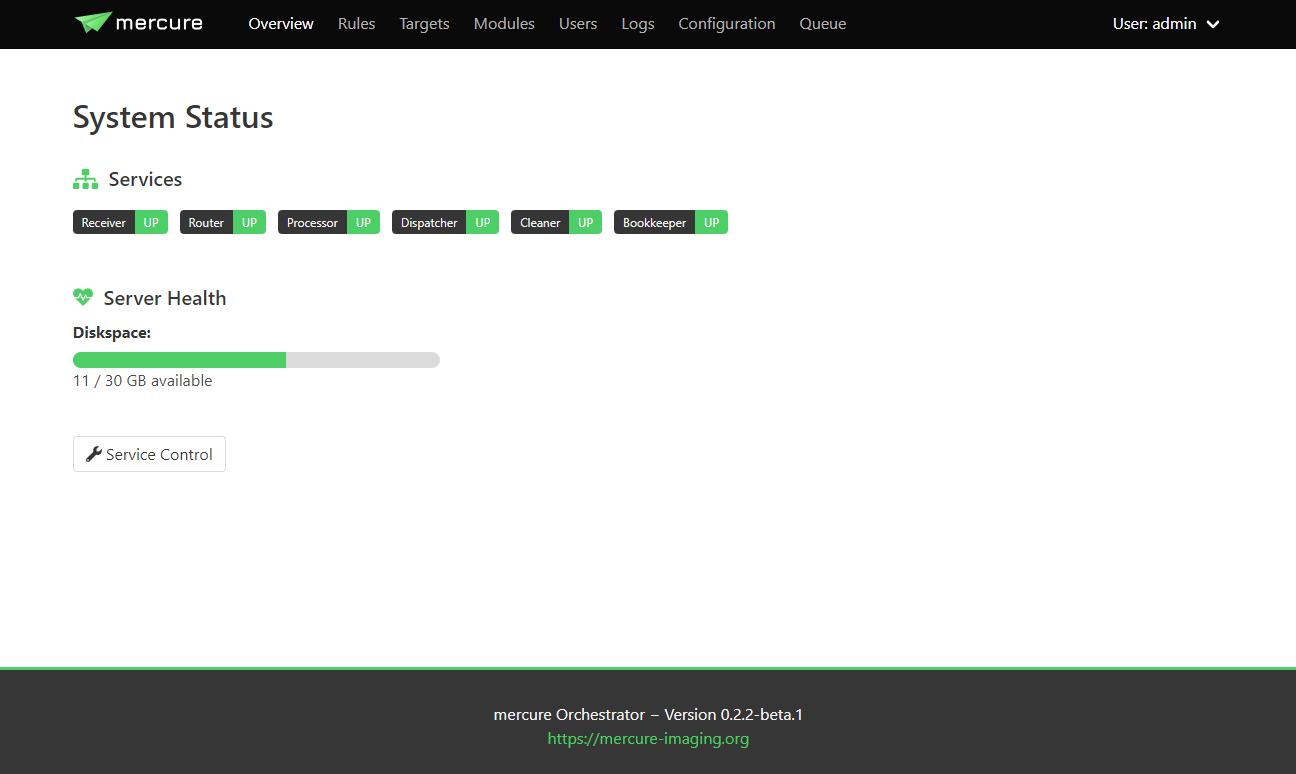

### 1.3 Install Offis DCMTK toolkit

We will send DICOM images to Mercure in this tutorial using the 'dcmsend' tool from the DCMTK tool kit which can be downloaded [here.](https://dicom.offis.de/en/dcmtk/dcmtk-tools/)

Once DCMTK is installed we verify connectivity using the command below.



In [ ]:
!echoscu -v 127.0.0.1 11112

A successful response should be received as below:

I: Requesting Association

I: Association Accepted (Max Send PDV: 16372)

I: Sending Echo Request (MsgID 1)

I: Received Echo Response (Success)

I: Releasing Association

## 2. Setup and test connection to Orthanc PACS

Orthanc PACS will be listening to DICOM connections at port 4242. To send images to Orthanc, it will need to be configured as a Target node in Mercure. Select the 'Targets' page in Mercure and click '+ Add New' to add a new target with the following settings:

Name: Orthanc

Type: DICOM Node

Host/IP: 127.0.0.1

Port: 4242

AET Target: Orthanc

AET Source: mercure

Click 'Save'

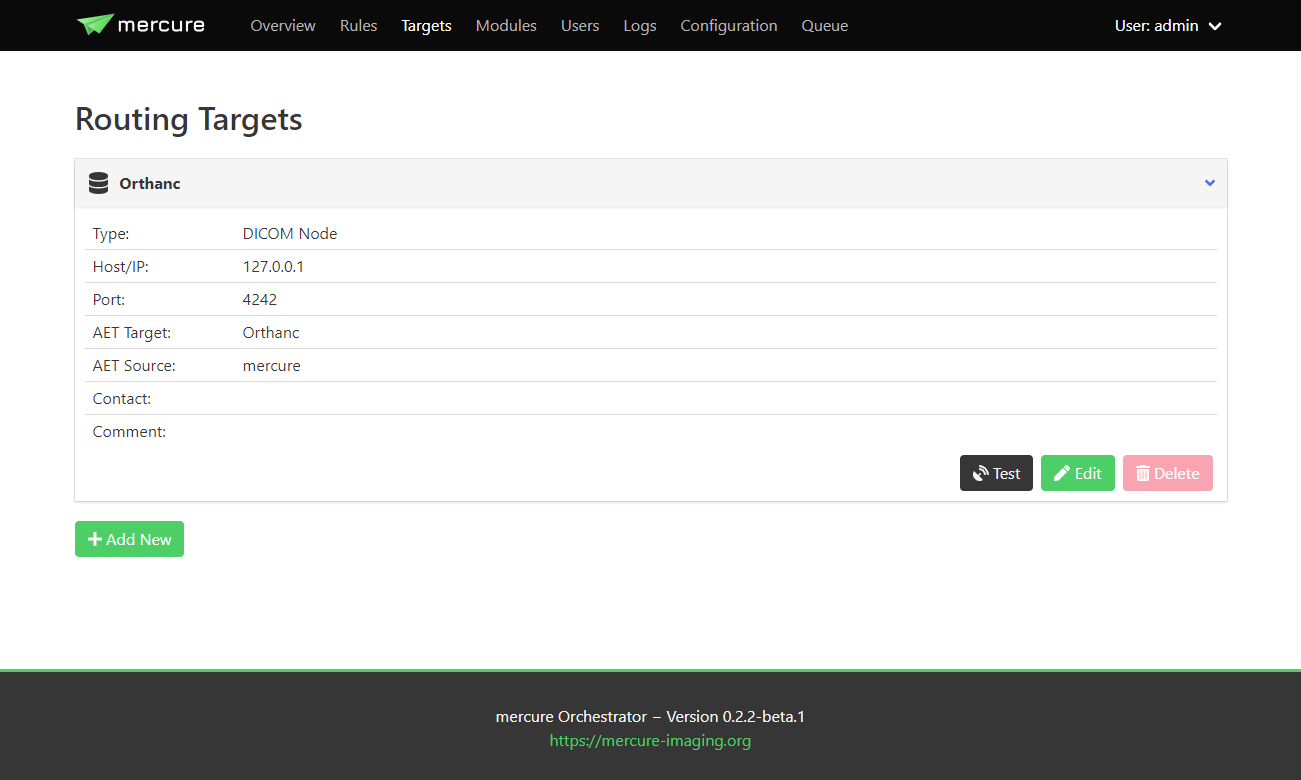

Test that Mercure can talk to Orthanc by clicking on the entry “Orthanc” in the target list and clicking “Test”. Both the Ping and C-Echo test should show a green check mark.

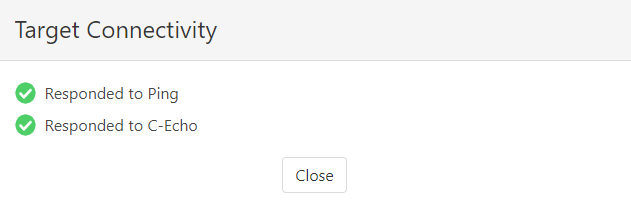

Check that you can open the Orthanc interface (Username = orthanc, Password = orthanc) in a web browser at the following address :

Orthanc: [127.0.0.1:8042](http://127.0.0.1:8042)


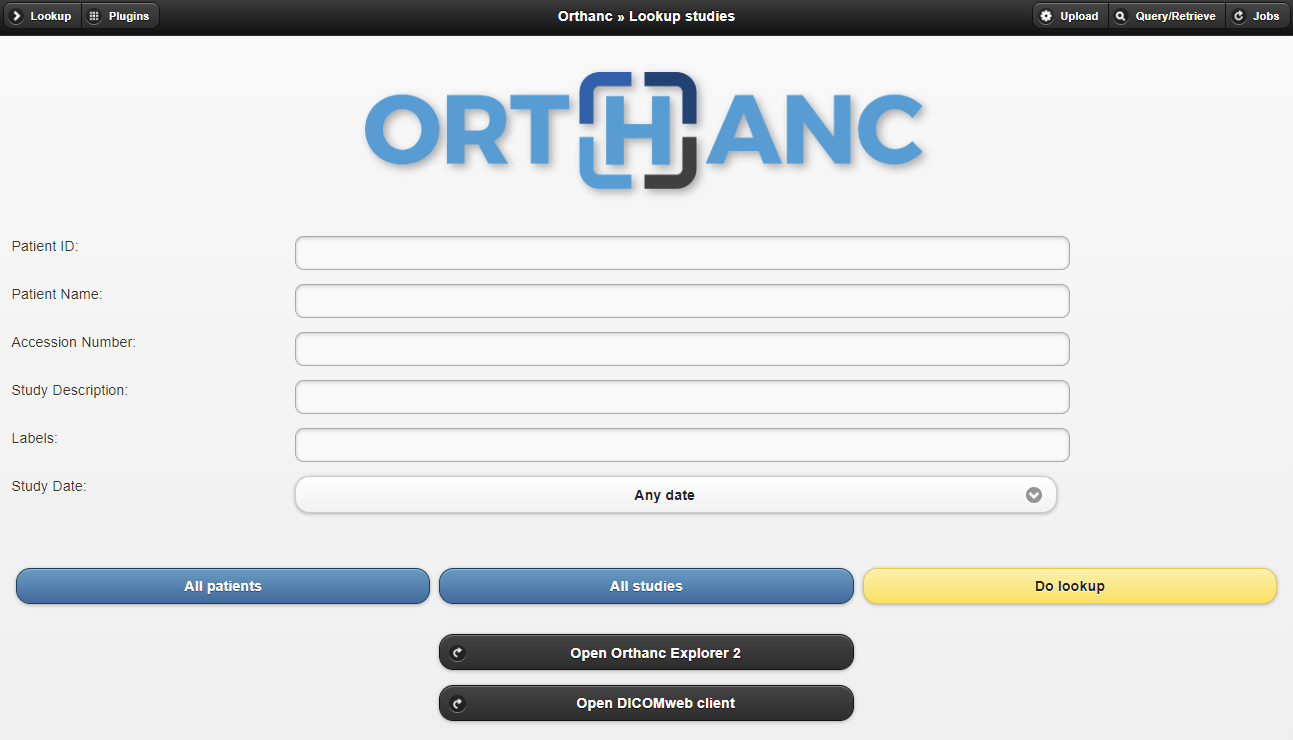

## 3. Configure a module in Mercure

To simplify deployment of the TotalSegmentator tool, a Docker image has been created to run this application as a module in Mercure. This module is named 'mercure-totalsegmentator' and has been made available on Dockerhub. We will use this prebuilt Docker image in this deployment, if you  are interested in the code for this module, please visit this [address.](https://github.com/mercure-imaging/mercure-totalsegmentator) 

Add this module to the Mercure installation by selecting the 'modules' page and clicking '+ Install Module' Button. Provide a name for the module, enter the Docker tag for the mercure-totalsegmentator module as shown below (mercureimaging/mercure-totalsegmentator), and click 'Install'.

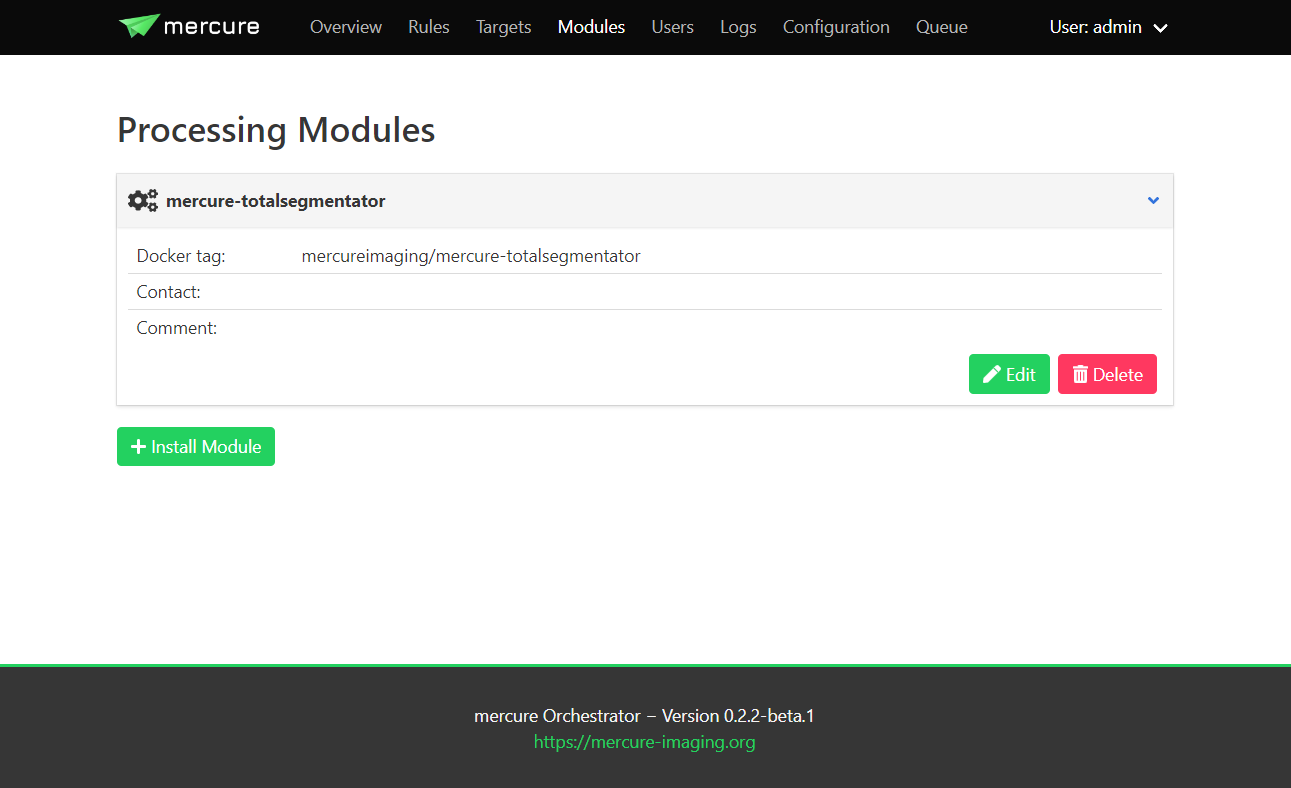

We will now setup a rule that will filter incoming image files and will trigger processing using the mercure-totalsegmentator module we installed in the previous step.

Select the 'Rules' page in Mercure and click '+ Add New' and provide an name such as 'totalsegmentator-rule'. Open the rule using the edit button and select the 'Filtering' tab to populate the fields as below and click 'Save' button :

Selection Rule = True

Action = Processing & Routing

Trigger = 'Completed Series'


The Filtering settings should look as in the image below, and will trigger processing and routing to be performed on all series sent to Mercure once all images in the series have been received.


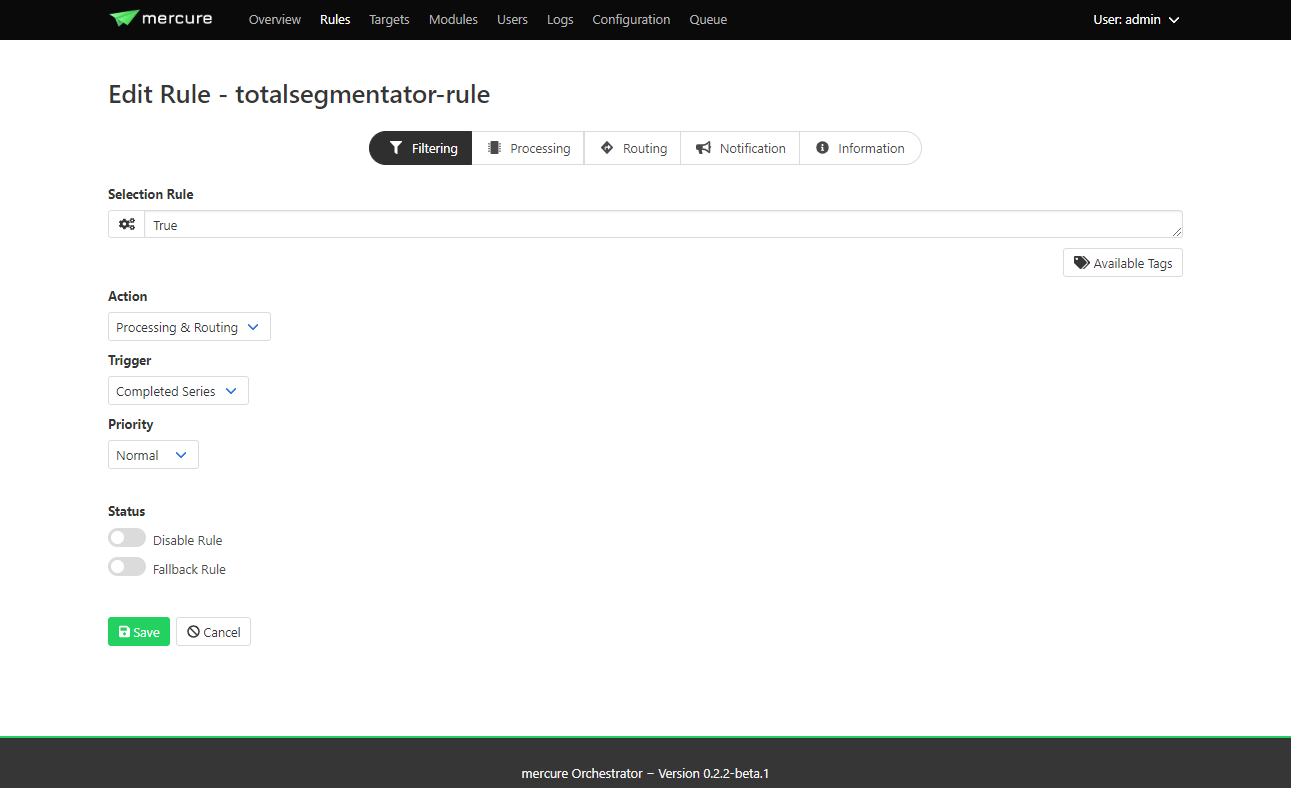

In the 'Processing' tab we will select the mercure-totalsegmentator module, and switch the DataFlow setting 'Retain Input Images' to the on position. In the 'Routing' tab we will select the 'Orthanc' target and then click 'Save'. This configuration is shown in the images below and is now ready for us to send some images to Mercure.

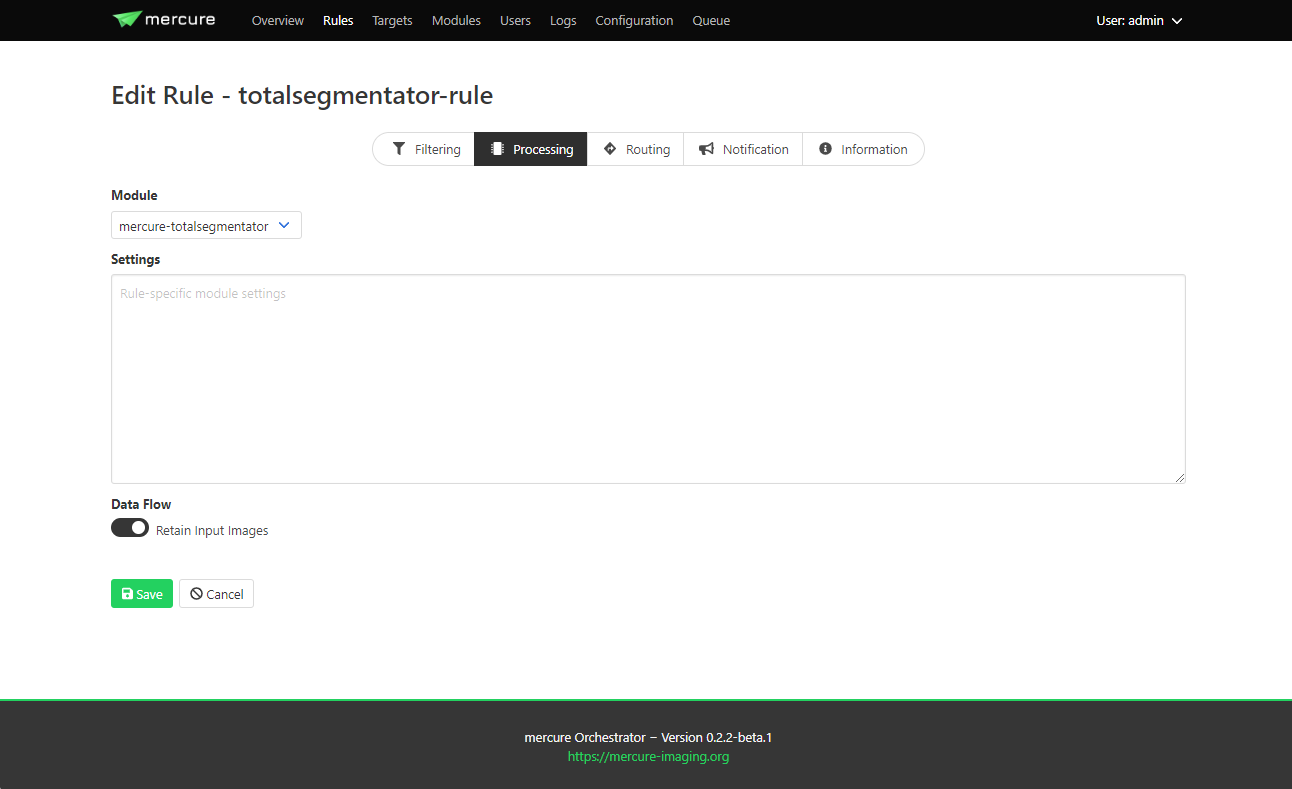

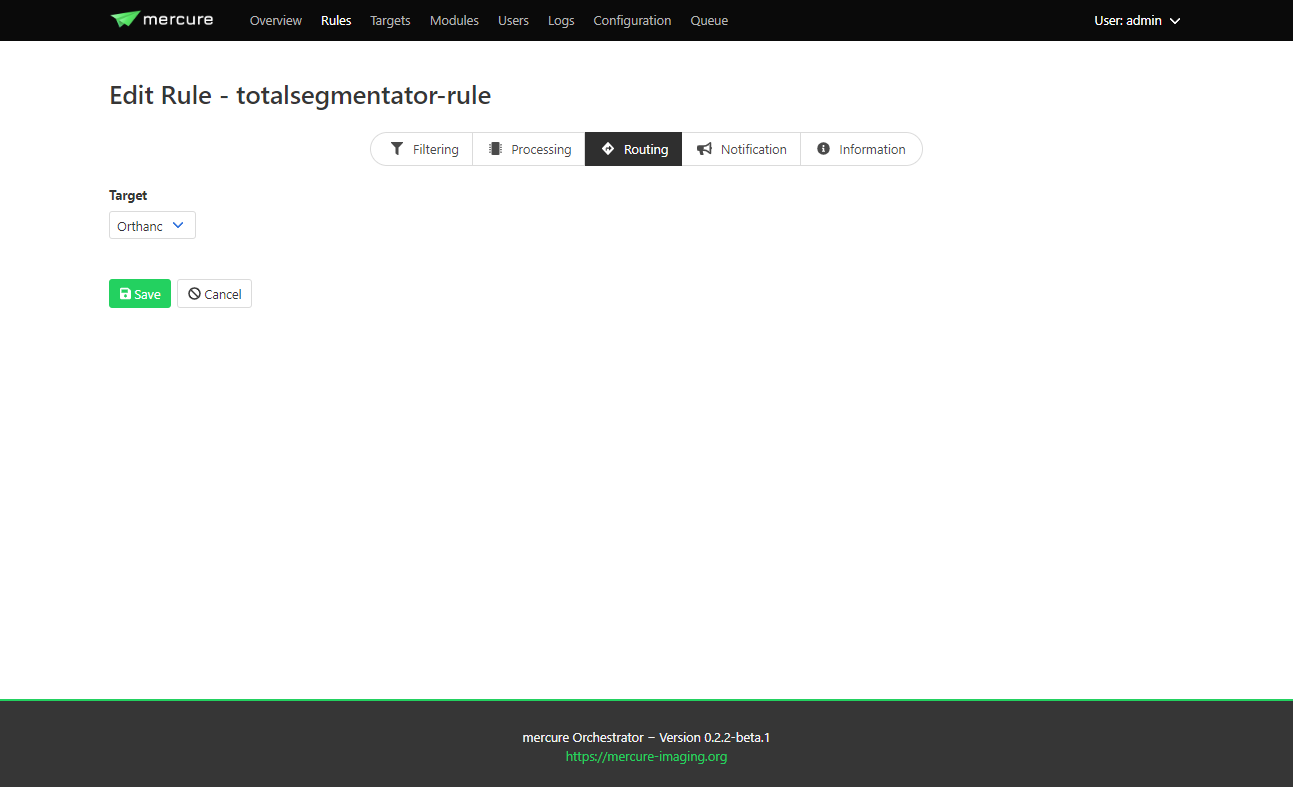

## 4. Send data for inference and view segmentation results

The mercure-totalsegmentator processing module performs segmentation of 104 anatomical structures in CT images. Run the cell below to download the MONAI test dataset:

In [ ]:
# Download the zip file containing both the model and test data
!pip install gdown
!gdown https://drive.google.com/uc?id=1Uds8mEvdGNYUuvFpTtCQ8gNU97bAPCaQ

Unzip and confirm that 'dcm' directory is extracted containing test dataset (204 DICOM files).

In [5]:
# for LINUX / macOS
#!unzip -o ai_spleen_seg_bundle_data.zip

# or for windows uncomment :
!tar -xf ./ai_spleen_seg_bundle_data.zip


Send DICOM images in test dataset to Mercure.

In [6]:
!dcmsend 127.0.0.1 11112 ./dcm/*.dcm

Select 'Queue' tab in Mercure, after a few minutes you should see that there is a job in the queue and the status has changed to processing. The refresh button in the top right can be used to update the page. 

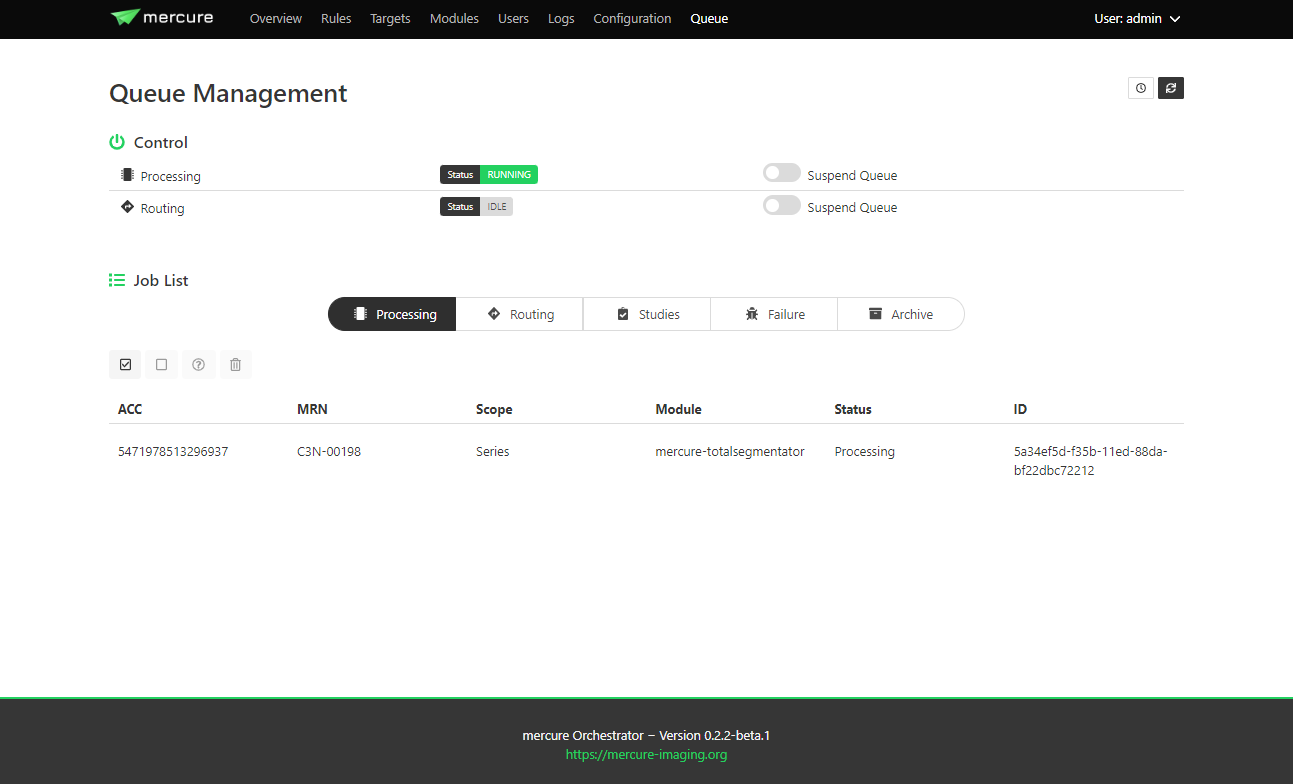

The first time a module is used, the Docker image must be downloaded from Dockerhub which may take a few minutes ( progress can be monitored in the 'Processor' tab in the 'Logs' page of Mercure). 

Once processing has finished it will disappear from the processig queue and the audit trail (as shown below) can be viewed by clicking on 'Archive' on the right hand side, , highlighting the entry in the job list by clicking on it, and then clicking on the 'Audit trail' button:

 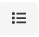

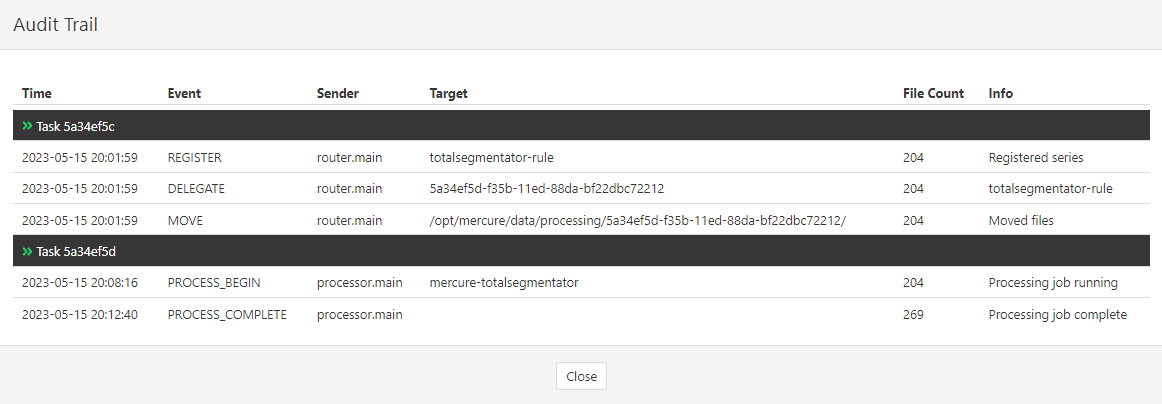

Open or refresh the orthanc web interface and click on 'All studies' button. The series just processed should appear in the study list as in the image below.

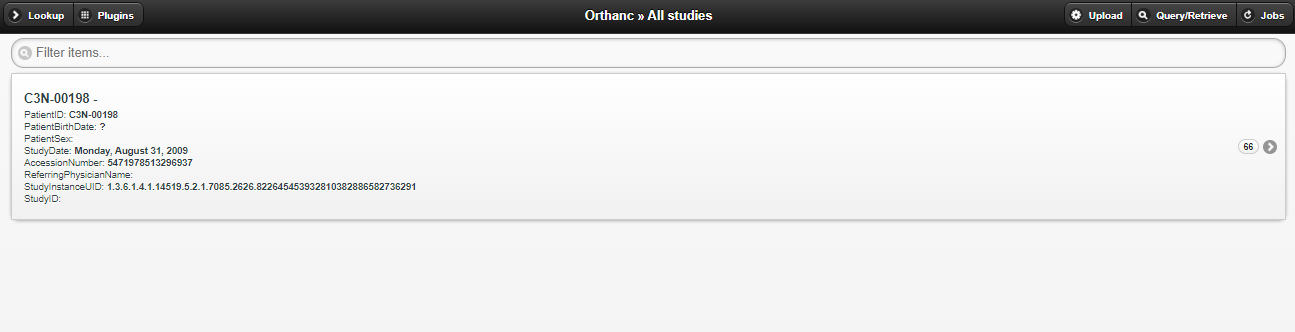

The results of the segmentation can be viewed using either the 'Orthanc Web Viewer' or the 'Stone Web Viewer'. To do so, after selecting 'All Studies'  click on the Study we have just processed 'C3N-00198'. Select the Series with the prefix 'Segmentation_masks_'. 

On the left hand side of the orthanc interface you will see a list of buttons with viewers and operations listed. Select 'Orthanc Web Viewer' or 'Stone Web Viewer' to view the segmentations ( if using Stone Web Viewer you will also need to double click the series to load into the viewer). 

A screen shot for the Stone Web Viewer is shown below.

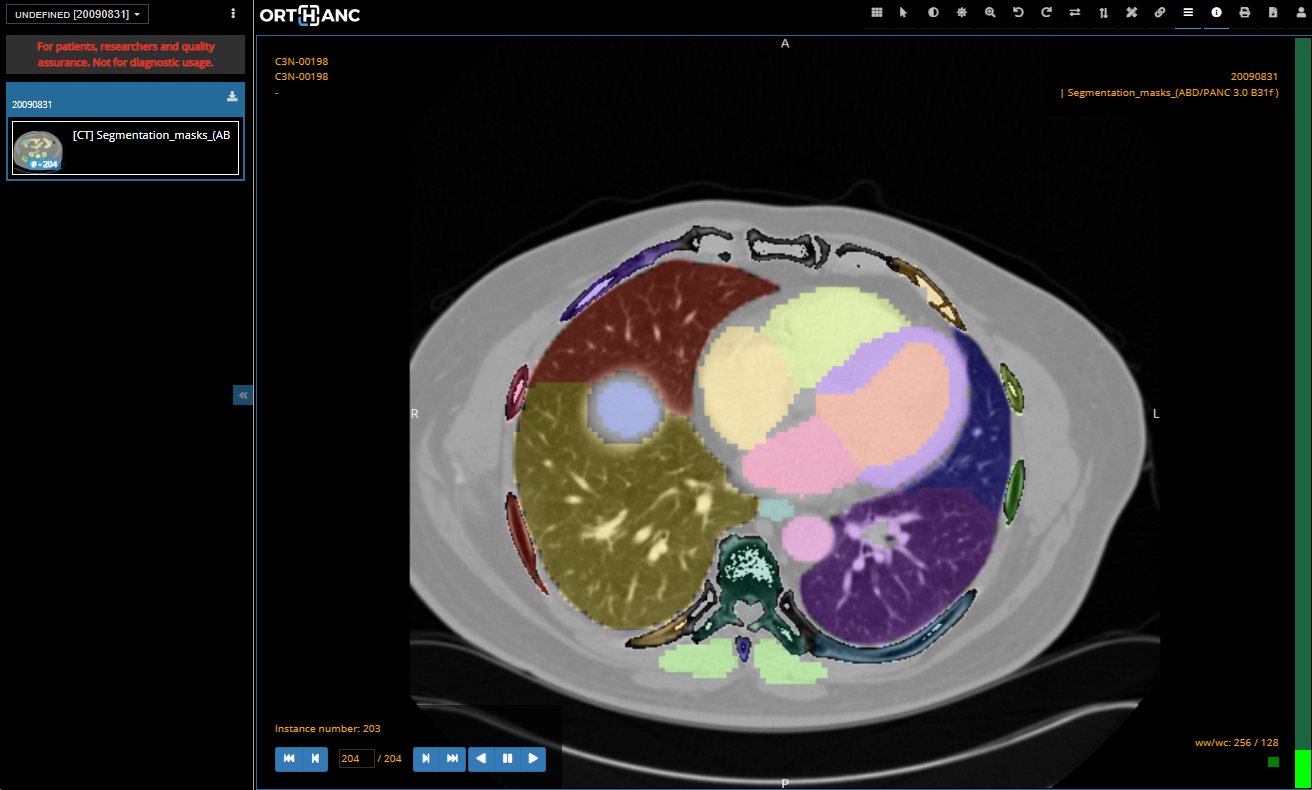

Congratulations, you have successfully installed Mercure and deployed the mercure-totalsegmentator module that can receive DICOM images, perform segmentation, and send results to PACS for viewing. 

More information can be found [here](www.mercure-imaging.org) on how to setup and configure Mercure for your specific DICOM orchestration requirements. There is also a chat feature on this website for questions not covered in the documentation or to report software issues and bugs. 

Further details on the mercure-totalsegmentator module can be found in the Mercure github repository [here](https://github.com/mercure-imaging/mercure-totalsegmentator).